We begin by importing three classes made from scratch: LogisticRegression, KFoldSplitSet, and NestedCV. In addition to these, numpy, pandas, and itertools is also imported.



In [1]:
from LogisticRegression import LogisticRegression
from SplitSet import SplitSet
from NestedCrossValidation import NestedCV
import pandas as pd
import numpy as np
import itertools

First, the mushroom dataset must be processed to appropriately train the logistic classifier. A header row is added and a class vector is constructed from the last column of the dataset.

In [2]:
# Load the data
mushroom_set = pd.read_csv('Mushroom.csv')
mushroom_headers = ['Poisonous', 'Cap-shape', 'Cap-surface', 'Cap-color',
                    'Bruises', 'Odor', 'Gill-attachment',  'Gill-spacing',
                    'Gill-size', 'Gill-color', 'Stalk-color-below-ring', 'Class']
mushroom_set.columns = mushroom_headers

# Get the labels from last column
X = mushroom_set.iloc[:, :-1]
Y = mushroom_set.iloc[:, -1]

An automated process was designed to choose candidate models that had the highest accuracy based on a nested cross validation algorithm. A hyperparameter grid was constructed to identify the best learning rate, regularization, and norm penalty.

In [3]:
hyperparameters = {
    'lr': [0.001, 0.03, 0.1],
    'reg': ['l1', 'l2'],
    'norm_penalty': [0, 0.3, 0.5, 0.8]
}
hyper_perms = list(itertools.product(*hyperparameters.values()))

# Remove l2 with 0 norm penalty since it's the same as l1 with 0 norm penalty
hyper_perms = [perm for perm in hyper_perms if perm[1] != 'l2' and perm[2] != 0]

A nested cross validation is performed with 10 outer folds and 3 inner folds to procure candidate models that perform the best in the grid search validation process. 10 models are brought forth, however only the unique models are considered.

In [4]:
# Perform nested cross validation to get candidate models
nested_cv = NestedCV(outer_folds=10, inner_folds=3, model=LogisticRegression,
                     hyperparameter_grid=hyper_perms)
candidate_models = nested_cv.get_candidate_models(X, Y)
print(candidate_models)

[(0.001, 'l1', 0.5), (0.001, 'l1', 0.3)]


The candidate models are then evaluated on the full mushroom dataset using a 10-fold cross validation.

In [5]:
# Evaluate the candidate models using a 10-fold cross validation
best_model = nested_cv.k_fold_cross_validation(candidate_models, X, Y)

Average accuracy for model with hyperparameters (0.001, 'l1', 0.5): 0.7438271604938271
Average accuracy for model with hyperparameters (0.001, 'l1', 0.3): 0.741358024691358


We can now do some analysis with the best model selected! First let's see how it used regularization to place less importance on some features.

In [6]:
# Generate splits
splits = SplitSet()
X_train, X_test, Y_train, Y_test = splits.split(X, Y, test_size=0.2)
x_train, x_val, y_train, y_val = splits.split(X_train, Y_train, test_size=0.2)

# Train the best model
best_model.fit(x_train, y_train, x_val, y_val)

# Check the weights per feature
headers = ['Intercept', 'Poisonous', 'Cap-shape', 'Cap-surface', 'Cap-color',
                    'Bruises', 'Odor', 'Gill-attachment',  'Gill-spacing',
                    'Gill-size', 'Gill-color', 'Stalk-color-below-ring']
weights = best_model.w
data = {'Feature': headers, 'Weight': weights}
weights_df = pd.DataFrame(data)
print(weights_df)

                   Feature    Weight
0                Intercept -0.271073
1                Poisonous  0.801186
2                Cap-shape -2.893331
3              Cap-surface  0.421767
4                Cap-color -0.000103
5                  Bruises -0.708560
6                     Odor  0.277365
7          Gill-attachment -2.537385
8             Gill-spacing -1.429586
9                Gill-size -0.000392
10              Gill-color  2.514651
11  Stalk-color-below-ring  4.867344


Early stopping is enforced by observing the performance of the model on a validation set during training. If the accuracy of prediction does not increase by more than 0.001 over 250 consecutive iterations, the model stops training. Let's see how this affects performance.

Test accuracy with no stopping (2000 iterations): 0.7407407407407407
Time elapsed: 0.7656104564666748


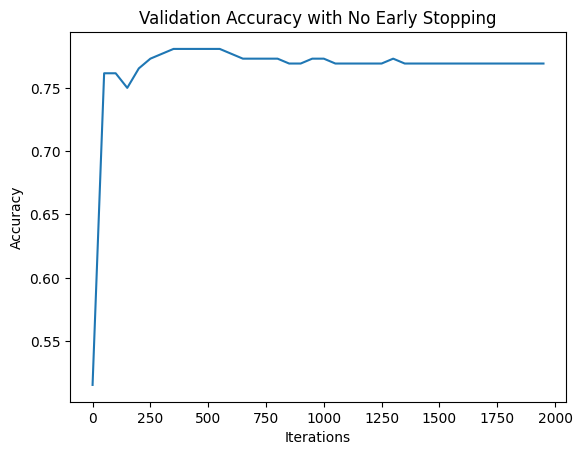

Test accuracy with stopping after 500 iterations: 0.7283950617283951
Time elapsed: 0.19710516929626465


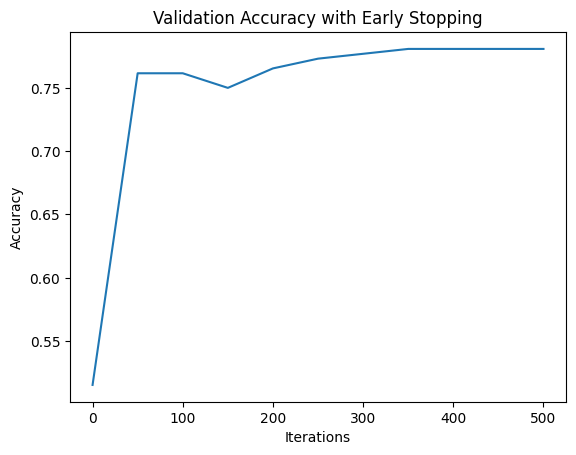

In [12]:
import matplotlib.pyplot as plt
import time

# Evaluate the best model with no early stopping
timer = time.time()
best_model.early_stopping = False
iterations, accuracies = best_model.fit(x_train, y_train, x_val, y_val)
Y_pred = best_model.predict(X_test)
accuracy = np.mean(Y_pred == Y_test)
print("Test accuracy with no stopping (2000 iterations):", accuracy)
print("Time elapsed:", time.time() - timer)

# Make a plot of the accuracy vs iterations
plt.plot(iterations, accuracies)
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy with No Early Stopping")
plt.show()

# Evaluate model with early stopping
timer = time.time()
best_model.early_stopping = True
iterations, accuracies = best_model.fit(x_train, y_train, x_val, y_val)
Y_pred = best_model.predict(X_test)
accuracy = np.mean(Y_pred == Y_test)
print(f"Test accuracy with stopping after {iterations[-1]} iterations:", accuracy)
print("Time elapsed:", time.time() - timer)

# Make a plot of the accuracy vs iterations
plt.plot(iterations, accuracies)
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy with Early Stopping")
plt.show()

With only a slight decrease in test accuracy, the training time is cut by an enormous amount thanks to an automated early stopping protocol.